
Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <http://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [0]:
%matplotlib inline

# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
!nvidia-smi

True
0
Fri Sep  6 14:17:57 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |     10MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.

This dataset is a very small subset of imagenet.

.. Note ::
   Download the data from
   `here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`_
   and extract it to the current directory.



In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

dirpath = 'drive/My Drive/Colab Notebooks/torch/'

data_dir =dirpath + 'dest'

# !ls sample_data
# !mkdir hymenoptera_data
# !curl https://download.pytorch.org/tutorial/hymenoptera_data.zip --output hymenoptera_data.zip
# !unzip hymenoptera_data.zip
# data_dir = "hymenoptera_data"

# ! cp -r drive/My Drive/Colab Notebooks/

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class_names, device, dataset_sizes

(['choki', 'goo'], device(type='cuda', index=0), {'train': 37, 'val': 19})

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



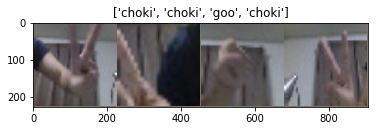

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()



    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
!rm -r ~/.cache/torch

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.






In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 24710579.62it/s]


Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [11]:
%time
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=1)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.25 µs
Epoch 0/24
----------
train Loss: 0.6626 Acc: 0.5946
val Loss: 0.8898 Acc: 0.5263

Epoch 1/24
----------
train Loss: 0.6413 Acc: 0.6757
val Loss: 0.6874 Acc: 0.5789

Epoch 2/24
----------
train Loss: 0.6197 Acc: 0.5676
val Loss: 0.5136 Acc: 0.8421

Epoch 3/24
----------
train Loss: 0.5966 Acc: 0.6486
val Loss: 0.4327 Acc: 0.7895

Epoch 4/24
----------
train Loss: 0.8093 Acc: 0.6757
val Loss: 0.4528 Acc: 0.7895

Epoch 5/24
----------
train Loss: 0.4421 Acc: 0.8108
val Loss: 0.4375 Acc: 0.7368

Epoch 6/24
----------
train Loss: 0.3903 Acc: 0.7838
val Loss: 0.3465 Acc: 0.8421

Epoch 7/24
----------
train Loss: 0.5889 Acc: 0.5946
val Loss: 0.3230 Acc: 0.9474

Epoch 8/24
----------
train Loss: 0.5630 Acc: 0.7027
val Loss: 0.3151 Acc: 0.8947

Epoch 9/24
----------
train Loss: 0.4343 Acc: 0.7838
val Loss: 0.3622 Acc: 0.8421

Epoch 10/24
----------
train Loss: 0.2991 Acc: 0.8919
val Loss: 0.3591 Acc: 0.8421

Epoch 11/24
----------

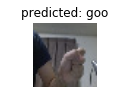

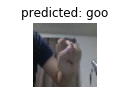

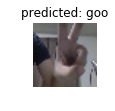

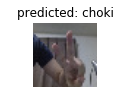

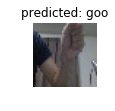

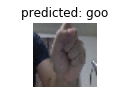

In [10]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [12]:
%time
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




In [13]:
%time
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

CPU times: user 1e+03 ns, sys: 1 µs, total: 2 µs
Wall time: 5.48 µs
Epoch 0/24
----------
train Loss: 0.7805 Acc: 0.3784
val Loss: 0.6630 Acc: 0.6842

Epoch 1/24
----------
train Loss: 0.7260 Acc: 0.6216
val Loss: 0.7374 Acc: 0.4737

Epoch 2/24
----------
train Loss: 0.6739 Acc: 0.5676
val Loss: 0.6844 Acc: 0.5263

Epoch 3/24
----------
train Loss: 0.8732 Acc: 0.5676
val Loss: 0.6613 Acc: 0.5789

Epoch 4/24
----------
train Loss: 0.6800 Acc: 0.6486
val Loss: 0.8548 Acc: 0.4737

Epoch 5/24
----------
train Loss: 0.7724 Acc: 0.5946
val Loss: 0.7492 Acc: 0.5263

Epoch 6/24
----------
train Loss: 0.5732 Acc: 0.6216
val Loss: 0.6573 Acc: 0.5789

Epoch 7/24
----------
train Loss: 0.5632 Acc: 0.6486
val Loss: 0.4476 Acc: 0.7895

Epoch 8/24
----------
train Loss: 0.5184 Acc: 0.7297
val Loss: 0.5131 Acc: 0.7368

Epoch 9/24
----------
train Loss: 0.5500 Acc: 0.7297
val Loss: 0.4947 Acc: 0.7368

Epoch 10/24
----------
train Loss: 0.4963 Acc: 0.7838
val Loss: 0.4940 Acc: 0.7368

Epoch 11/24
------

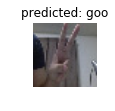

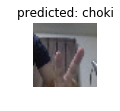

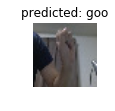

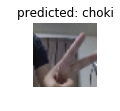

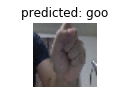

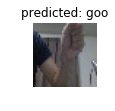

In [14]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [0]:
# !mkdir predict_data
# !curl https://pestworldforkids.org/media/6286/Pavement-ant.jpg -o predict_data/ants.jpg

# !ls predict_data

!curl http://i.gzn.jp/img/2015/08/23/why-bee-die-after-sting/00-top_m.jpg -o predict_data/bee2.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 19291  100 19291    0     0  19664      0 --:--:-- --:--:-- --:--:-- 19644


In [0]:
%time
from PIL import Image

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

image = Image.open('predict_data/bee2.jpg')
image = data_transform(image).unsqueeze(0).cuda()

out = model_conv(image)
# Find the predicted class
print("Predicted class is: {}".format(class_names[out.argmax()]))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
Predicted class is: bees
